# Labs 7 - 10: A CA model of Natural Disturbance
In [1990](https://doi.org/10.1016/0375-9601(90)90451-S) Bak, Chen and Tang proposed a cellular automaton that is an abstract model of a forest fire. Each cell is in one of three states: empty, occupied by forest, or on fire.

3 ecological processes are modelled: forest regeneration, fire ignition, and fire spread

  * empty cells "regenerate" forest at a fixed rate, $p$
  * forest fires ignite with a regular but small frequency, $f$
  * forested cells catch fire when their neighbours are burning, and burn out in one time step.

Over the remainder of term, we will develop 2D CA class that implements this model and run computational experiments on the spatial and temporal patterns that emerge.

#Citations

Used for scipy/correlate2d: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html

Used for numpy help: https://numpy.org/doc/stable/reference/generated/numpy.where.html

Other:https://www.geeksforgeeks.org/difference-between-and-and-in-python/

+Got some ideas help from a friend, specifics commented in the step function.

In [1]:
%matplotlib inline

import time
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from scipy.signal import correlate2d
from scipy.stats import linregress
import random

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

### Helpers
Some useful, re-usable bits of code developed in previous notebooks...

In [2]:
'''
DEFAULT_IMSHOW_OPTIONS = dict(     #changed to color map below from patchify.ipynb
    cmap='Blues',
    interpolation='none',
    origin='upper',
)
'''

tab20_mod = matplotlib.colormaps['tab20']
tab20_mod.colors = ((1,1,1,1), *tab20_mod.colors[1:])

DEFAULT_IMSHOW_OPTIONS = dict(
    cmap=tab20_mod,
    interpolation='none',
    origin='upper',
)

def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

In [3]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

# Lab 7:  Implementing the Bak, Chen, Tang Model

In this lab we will implement a 2D CA model using the same techniques as the GoL, Diffusion, and Percolation models.
We are setting up the model we will use in future labs to run some computational experiments to answer questions about this system.

## Ex. 7.1: Define the Cellular Automata
This 2D CA will be similar to those we've seen before.

1. Define the kernel (correlation matrix)
    * what do we need to know about a cell's neighbourhood?
    * how can we encode that using a dot product with a 3 x 3 correlation matrix?

2. The step function will be more complex because it must implement the 4 rules:

  *  An empty cell becomes occupied with probability $p$.
  *  A cell with a tree burns if any of its neighbors is on fire.
  *  A cell with a tree spontaneously burns, with probability $f$, even if none of its neighbors is on fire.
  *  A cell with a burning tree becomes an empty cell in the next time step.

Typical values for the parameters are $p=0.01$ and $f=0.001$

In [4]:
class ForestFire:
    """ 2D Cellular Automaton that simulates a fire-dominated landscape """

    # Define names for the 3 possible cell states
    EMPTY = 0
    OCCUPIED = 1
    FIRE = 5

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(1, 0.5, 0), (0, 1, 0), (0, 0, 0), (0, 0, 0), (0, 0, 0), (1, 0, 0)]
    cmap[EMPTY] = (1, 0.5, 0)  # brown
    cmap[OCCUPIED] = (0, 1, 0)  # green
    cmap[FIRE] = (1, 0, 0)  # red
    forest_colour_map = matplotlib.colors.ListedColormap(cmap)

    # TODO: define a sensible correlation kernel
    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]])


    def __init__(self, n, p=0.01, f=0.001, q=0.5):
        """Initializes the model.

        n: number of rows
        p: probability an empty cells becomes "forested" (occupied)
        f: probability of spontaneous file (e.g., 1/fire ignition interval)
        q: initial forest density (probability cell is "forested" in initial state)
        """
        self.p = p
        self.f = f
        self.n = n
        # initialize landscape with approx. q proportion of cells OCCUPIED
        self.array = np.random.choice([self.OCCUPIED, self.EMPTY], (n, n), p=[q, 1 - q])


    def step(self):
        """Executes one time step, applying the CA rules to regenerate and burn forest."""
        new_state = np.where((self.array == self.EMPTY) & (np.random.rand(*self.array.shape) < self.p),       #Was helped and given the idea to use np.where () and the *
                             self.OCCUPIED, self.array)#When condition is true, empty and less than p, return x, = self.OCCU, and when false, return y, self.array         #Was also helped to understand the & operator, was able to work the rest out afterwards.
        burning = (self.array == self.FIRE)
        burning_beside = correlate2d(burning, self.kernel, mode='same') > 0 
        new_state[(self.array == self.OCCUPIED) & burning_beside] = self.FIRE
        new_state[(self.array == self.OCCUPIED) & (np.random.rand(*self.array.shape) < self.f)] = self.FIRE
        new_state[self.array == self.FIRE] = self.EMPTY

        self.array = new_state

    def num_occupied(self):
        """ return the number of cells occupied by forest """
        x = np.sum(self.array == self.OCCUPIED)
        return x  # TODO: count the number of forested cells.


    def pct_occupied(self):
        """ return the proportion of cells occupied by forest """
        return self.num_occupied() / self.array.size


    def draw(self, axes=None, step=''):
        """Draws the CA cells using the forest colour map so values are coloured intuitively."""
        axes = axes or plt.axes
        title = f'Time:{step} Occupied: {round(self.pct_occupied() * 100, 2)}%'
        plot_2D_array(self.array, axes=axes, title=title,
                      cmap=self.forest_colour_map, vmin=0, vmax=len(self.forest_colour_map.colors))

In [5]:
# Code-a-little Test-a-little - use this space to test your class methods as you develop them.  You can remove this block when done.
m = ForestFire(3, p=0.5, f=0.2)  #  a very small model with high chance of regen. and spontaneous fires
m.array = np.array([             # set the state matrix to a known value for testing with
    [0, 1, 0],
    [1, 5, 0],
    [0, 0, 0],

])
m.step()                          # test the method you are working on and print some useful indicator
pprint(m.array)

array([[1, 5, 1],
       [5, 0, 1],
       [0, 0, 0]])


## Ex. 7.2: Animation
Create a simple animation (using Animate2D class provided) so we can visualize and verify the system dynamics

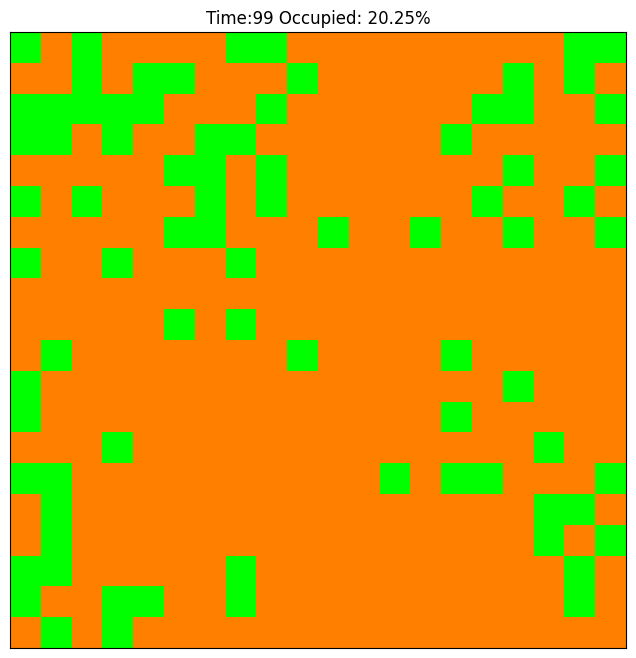

In [6]:
# Ex. 7.2 here
#  Suggestions: use a small grid (e.g., 20x20)  and
#               a short animation (100 frames) with interval=0.3, to slow it down so you can inspect its behaviour

h = ForestFire (20)
b = Animation2D (h, 100)

b.animate (0.3)




### Question 7.3:
In what ways is this model similar to Diffusion and/or Percolation?
What kinds of behaviours might we predict from this more complex model based on what we learned from the simpler Diffusion and/or Precolation models?
Provide concise (brief, point-form) answers below:

#### Answers:
This model is very similar to percolation as it can viewed as if the trees are a very porous material, and the empty spots are "non-porous", and the fire is the fluid moving through. 

From what I have seen so far with diffusion and percolation is that seemingly minor changes to the model can cause very major changes in how the simulation plays out. In the case of diffusion, such minor things such as the feed/kill, changed the entire model and allowed to create complex patterns from such a simple change. I would not be suprised if a small change such as the feed/kill applied on to this model would also result in much more complex simulations and perhaps patterns.

-------------------



# Lab 8:  Temporal Dynamics: Stability and Equilibrium

The [dynamics](https://en.wikipedia.org/wiki/System_dynamics) of a system describe how it changes over time.  In mathematics, we typically express dyanamics with differential equations (i.e., expressing change over time).  In computation, we typically use a simulation model, like the one developed in Lab 7.

Please watch: [Basic System Dyanmics (15 min)](https://youtu.be/qlRM1JlxfkU) for a quick introduction to these concepts.

---------------------
In this lab we will explore the patterns our `ForestFire` model traces out over time.  We'll try to determine if the model is stable or chaotic, whether there are any circumstances where it reaches [equilibirum](https://en.wikipedia.org/wiki/Mechanical_equilibrium)

## Ex. 8.1: Exploratory Analysis
Explore the behaviour of the model we defined above.
 1. Alter the model's initial conditions - how does the behaviour change depending on the initial proportion of forested vs. empty cells?
 2. Alter the regeneration and fire frequency parameters, $p$ and $f$, to see how this changes the model behaviour - how does the behaviour change as you increase or decrease each of these model parameters?

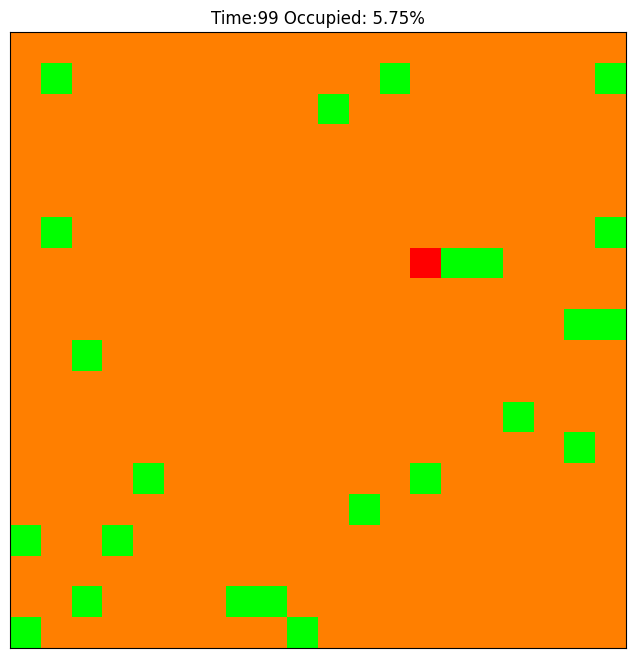

In [7]:
# Ex. 8.1 here

#When the initial proportion of forested cells is low, there is less chance of a large fire to occur
#immediately, and when q is high, it is likely that a large fire burning most of the cells will occur


k = ForestFire(20, p=0.001, f=0.01, q=0.5)
c = Animation2D (k, 100)
c.animate (0.3)



#Increasing the p value causes tree's to spawn more frequently, and increasing the f value causes the chance of fire beginning to go up. If p is = 0, even if the f value is vaslty small, as long as one fire begins it will continue to burn
#As well as if the f value is 1, trees that are growing will only last one time step.

## Ex. 8.2: Steady State
Many complex systems never achieve a static [equilibirum](https://en.wikipedia.org/wiki/Mechanical_equilibrium), instead their state fluctuates around a value, called an ["attractor"](https://en.wikipedia.org/wiki/Attractor).  A system that is not trending is said to be in ["steady state"](https://en.wikipedia.org/wiki/Steady_state).
Starting from a random initial condition, run the model until it reaches a "steady state" where the number of occupied cells is no longer trending (consistently increasing or decreasing).

Design an experimental setup that allows you to detect when the system is in steady state with respect to the number of forested cells.
This need not be fancy and need not automate the detection of steady state, so long as it provides some output that allows you to detect how long it takes for the system to settle into an equilibrium or cyclical pattern.

<Axes: xlabel='Timesteps', ylabel='Percent Occupied'>

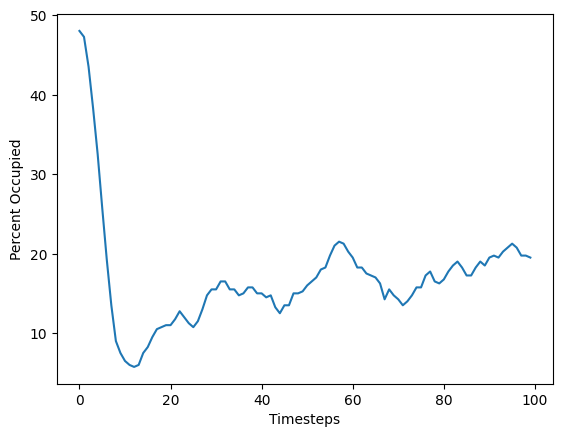

In [8]:
# Ex. 8.2 here

firefire = ForestFire(20, p=0.01, f=0.01, q=0.5)
fig, ax = plt.subplots ()
x = []
y = []

for i in range (100):
  firefire.step()
  occu = firefire.pct_occupied () * 100
  x.append (occu)
  y.append (i)


ax.plot (y, x)
ax.set_xlabel("Timesteps")
ax.set_ylabel("Percent Occupied")
ax




### Question 8.3:
Starting with a uniform random landscape, $q$ = 0.5, find the steady state proportion of forested cells of this system for 3 different combinations of $p$ and $f$, and the approx. number of time steps required to reach steady state.
Fill in the table below with your experimental results:

| p  | f   | steady-state | time steps | Cyclical? |
|----|-----|--------------|------------|-----------|
| 0.01 | 0.001 | 10% - 30%      | 25          | Yes       |
| 0.01 | 0.01   | 10% - 20%           | 10       | Yes        |
| 0.001  | 0.01   | 5%           | 17        | No         |


#Just to confirm in case I have read this wrong:
<font color='red'>
steady-state = the percentage of occupied cells where/when it is no longer increasing or decreasing.

timesteps = timesteps it takes to reach the first steady-state.

cyclical = whether or not it repeats the sequence of:
steady-state -> decrease -> increase -> steady-state.
</font>

I put for example: 10% - 30% as that is the range of the steady state, and the attractor would be a value in that range, but even if it is in that range, it is still possible for the pct occupied to go out of it, as this model does still have randomness invlovled

I also am not entirely sure if p 0.001, f 0.01 is cyclical as it seems to just stay stable at the steady state, but doing 1000 timesteps there is some change, but to me it really doesnt look like it's following a cycle

## Ex. 8.4: Stability
A system is ["stable"](https://en.wikipedia.org/wiki/Ecological_stability) if it returns to its former steady state after a [disturbance](https://en.wikipedia.org/wiki/Disturbance_(ecology))

A disturbance in our case might be an extreme fire year or an insect outbreak that changes the forest's susceptibility to fire, or several years of reduced regeneration due to a soil fungus killing seedlings.
How could you emulate a disturbance like this in your model?  If you want to modify the model in some way, that's OK, but you may also find ways to emulate a disturbance as an "external forcing function".

Run your model to steady-state, then emulate a major disturbance (over one or more time steps) to "perturb" the system away from its steady state.  Remove the external force and measure how long it takes for the system to return to steady state.

<Axes: xlabel='Timesteps', ylabel='Percent Occupied'>

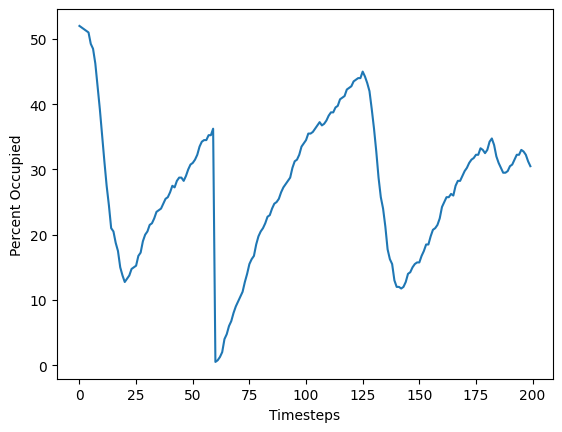

In [9]:
# Ex. 8.4 here


Simu = ForestFire(20, p=0.01, f=0.001, q=0.5)
fig, ax = plt.subplots ()
xx = []
yy = []
for i in range (200):
  if i == 60:      # Timestep 60 is in steady-state for the initial p, f, and q values. Not sure how else to "detect" when it's in its steady state besides knowing a timestep value beforehand.
    Simu.f = 1
  elif i == 61:
    Simu.f = 0.001
  Simu.step()
  occupied = Simu.pct_occupied () * 100
  xx.append(occupied)
  yy.append (i)

ax.plot (yy, xx)
ax.set_xlabel("Timesteps")
ax.set_ylabel("Percent Occupied")
ax


### Question 8.4:
Does the model tend to return to the same steady-state, or does the attractor move to a different value?
How long does it take for the model to return to steady-state dynamics?
Does it appear to matter to these results how large the disturbance is?
What does that tell you about the number of "attractors" in this system?

#### Answers:
<font color = "blue">

The model does tend to return to the same steady state, and it seems as it begins to return to that steady state immediately. It does not seem to matter how large the disturbance is, it alway's returns to the same steady state, therefore this says there is only one attractor in the system.

-----------------

# Lab 9: Patch Size Distribution

The spatial patterns that emerge from this model tends to be landscapes with patches of forested and un-forested land of varying size.  A question naturally arises about this pattern:
  * what is the size of patches created by fire?
    This will alos tell us something about forest [fragmentation](https://en.wikipedia.org/wiki/Habitat_fragmentation), which impacts wildlife habitat, for example.

Notice that rather than a single number, we will get a [distribution](https://en.wikipedia.org/wiki/Probability_distribution) of values for patch sizes.  The shape of this distribution emerges from the system dynamics, and serves as a way to compare our model results with empirical observations of patch-size distributions in real ecosystems.

In this lab we will explore the spatial patterns our `ForestFire` model makes.  We'll ask if these patterns have a [heavy-tail distribution](https://en.wikipedia.org/wiki/Heavy-tailed_distribution) and thus exhibit [self-organizing criticality](https://en.wikipedia.org/wiki/Self-organized_criticality)

### Identifying Contiguous Patches

This is a surprisingly challenging problem to solve in the general case given how good our visual system is at identifying them!
The idea I had here was to start by giving each forested cell a unique value, then "grow" patches by allowing the smallest of these unique values to propagate to neighbouring cells.  Repeat until the propagation is finished.  In the end, all the cells in each contiguous patch have the same, unique identifier.
Notice that this is a modified diffusion / percolation algorithm - they are actually useful!

In [10]:
neighbourhood = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0],
])


def min_neighbour(a):
    """ Return the smallest non-zero neighbourhood value or 0 if centre cell is a zero """
    p = a * neighbourhood
    centre = tuple(d // 2 for d in a.shape)
    return np.min(p[p > 0]) if a[centre] else 0


def consolidate(array):
    """ return copy of array with adjacent cells consolidated into a patch with the lowest value among occupied neighbours """
    rows, cols = array.shape
    k = neighbourhood.shape[0]
    array = np.pad(array, 1, 'constant')
    return np.array([
        [min_neighbour(array[row:row + k, col:col + k]) for col in range(cols)]
        for row in range(rows)
    ])


def patchify(array, patch_category):
    """ Return an array with each contiguous patch identified by a unique integer
    array:  array of int categorical values
    category: the category value to identify patches for

    return: array of same shape with a unique value identifying cells in each patch and zeros elsewhere
    """
    patches = np.zeros(array.shape, dtype=np.uint)
    # assign each cell that falls in a patch a unique number, 1 .. N
    patches[array == patch_category] = range(1, len(array[array == patch_category]) + 1)

    patches_growing = np.array([True, ])
    while np.any(patches_growing):
        prev_patches = patches
        patches = consolidate(prev_patches)
        patches_growing = patches != prev_patches  # patches are growning until consolidate algorithm stabilizes.

    return patches

## Ex. 9.1 Patch Size Distribution

Run your model to steady-state, and `patchify` the model state.
You might want to plot these beside each other to verify that `patchify` is working as expected.

With a unique value assigned to each patch, we can tally up the size of each patch simply by counting the number of cells for each unique value.
*Tip*: use [numpy.unique](https://numpy.org/doc/stable/reference/generated/numpy.unique.html), with `return_counts=True`, which does exactly the job we want.

Once you have an array of patch-size counts, create a histogram to display the distribution of patch sizes.
You could feed the raw patch-size count data to [pyplot.hist](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html), but you'll get a much nicer graph if you tally the number of patches in each size class yourself and use [pyplot.bar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html) to do the plotting.
*Tip*: `np.unique` will also tally up the number of patches in each size class from the patch-size array!

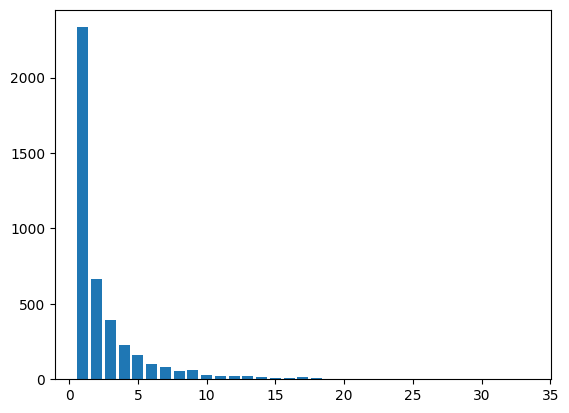

In [11]:
# Ex. 9.1 here

yup = ForestFire(200, p=0.01, f= 0.001, q=0.5)

for i in range (60): #60th time step is in the steady state range, not sure how to get when it's in it's in it's steady state another way
  yup.step ()

model = np.copy (yup.array)

model_state = patchify(model, 1)

#plot_2D_array(model_state)

id, size = np.unique(model_state[model_state>0], return_counts=True)

#for i in range(len(k)):
    #print(f"Patch {k[i]} has {j[i]} cells.")

def other_graph (id, size):
  ''' Graphs where x is the ID of the patch, and y is the patch size'''
  plt.bar(id, size)
  plt.xlabel ('Patch ID')
  plt. ylabel ('Patch size')
  plt.title ('other graph')

def distribution_graph (id, size):
  max = np.max (size)
  num_per = np.bincount (size, minlength=max) #Got help from friend, but was not given code, just given ideas/ideas on why something wasnt working.
  plt.bar(range(1, max+1), num_per[1:])


distribution_graph (id, size)

## Ex. 9.2 Heavy-tailed distribution?
The textbook author published a small Python package that encapsulates some of the work we did above to compute the "empirical distribution" from an array of data.  In paricular, his `PMF()` ([Probability Mass Function](https://en.wikipedia.org/wiki/Probability_mass_function)) function converts an array of unique values into an emirical distribution suitable for plotting

You can see how this function is used in Ch. 10.5.
And/Or check how it is used in the [chap10.ipynb notebook](https://github.com/pearcej/complex-colab/blob/master/notebooks/chap10.ipynb) in the complex-colab repo.
And/Or look at the [API Documentation](https://nbviewer.org/github/AllenDowney/empiricaldist/blob/master/empiricaldist/dist_demo.ipynb)

In [13]:
#!pip install empiricaldist
from empiricaldist import Pmf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.6.8-py3-none-any.whl size=12122 sha256=3ae49b73bd599e807f53f1deb826c3cc0b331add9ac59cffed53265352c2c6eb
  Stored in directory: /root/.cache/pip/wheels/c2/2f/73/700abc644ee5aba92a8b40552794103c445cd47fcdfe7828f7
Successfully built empiricaldist


Create a plot of the patch size distribution, both on a linear and log-log scale, similar to the example in Ch. 10.5

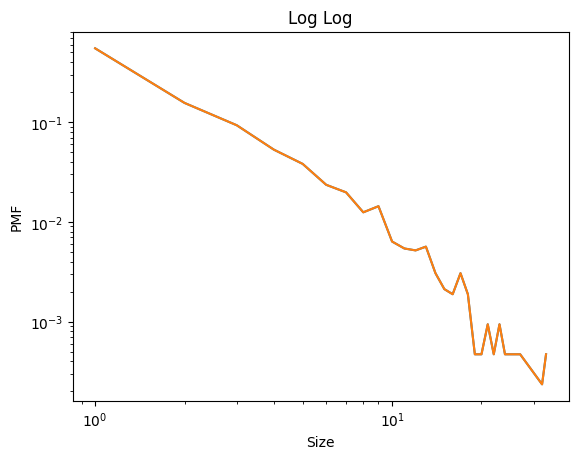

In [14]:
# Ex. 9.2 here

pmfJ = Pmf.from_seq(size)
pmfJ.plot ()

def draw_linear (pmfJ):
  plt.title ("Linear")
  plt.xlabel ('Size')
  plt.ylabel ('PMF')

def draw_loglog (pmfJ):
  plt.loglog(pmfJ)
  plt.title ("Log Log")
  plt.xlabel ('Size')
  plt.ylabel ('PMF')

draw_loglog (pmfJ)

### Question 9.3

Does the patch size distribution appear to follow the power law?
Does it show any signs of being a "heavy-tailed" distribution?
If it does, what might the implications be for our understanding of the dynamics of real forest ecosystems?

#### Answers
The patch size distribution does seem to follow the power law, yet drops off after a certain point. It does show signs of being heavy tailed meaning that in a real forest ecosystems, they are open to rare but extremely damaging effects.

# Lab 10:  Fractal Dimension

I highly recommend you start with this [**_2Blue1Brown Video_**](https://youtu.be/gB9n2gHsHN4), if you've not yet seen it.

-----------------
In this lab we will calculate the [fractal dimension](https://en.wikipedia.org/wiki/Fractal_dimension) of the forested areas thatour `ForestFire` model generates.

## Ex. 10.1 Box Counting

We'll use the [box counting](https://en.wikipedia.org/wiki/Box_counting) algorithm, which, in essence, estimates how the measured amount of forested area scales at different sized counting grids (2D rulers).  You are welcome to pilfer the `box_count` code developed for measuring fractal dimension in the **Precolation** model.

Run your model forward to steady-state, and use the box counting algorithm to estimate how the pattern of forested patches scales.  The result here show how the count of "forested" cells scales with the size of the "box" (grid cell) used to do the counting.
Just looking at the results, do you think this is closer to a linear or a squared scaling factor?

In [15]:
# Ex. 10.1 here
fractal_test = ForestFire(200, p=0.01, f= 0.001, q=0.5)

def box_count(array, calibre, target=fractal_test.OCCUPIED):
    rows,cols = array.shape
    grid = (array[i:i+calibre, j:j+calibre] for i in range(0, rows-calibre+1, calibre) for j in range(0, cols-calibre+1, calibre))
    return sum(target in window for window in grid)

for i in range (60):
  fractal_test.step ()

calibres = np.array([2,5,10,25,50,100])
counts = [box_count(fractal_test.array, i) for i in calibres]
print (counts)






[6793, 1565, 400, 64, 16, 4]


## Ex. 10.2  Estimate Fractal Dimension

If we plot the count of forested cells versus the size of the "box" on a log-log scale, the slope estimates the fractal dimension.

Estimate the slope of your box-count data using a log-log linear regression (again, feel free to pilfer the `log_slope` function).
Plot the graph that shows the box-count data in relation to a simple linear and square scaling relation (again, pilfer code as needed).

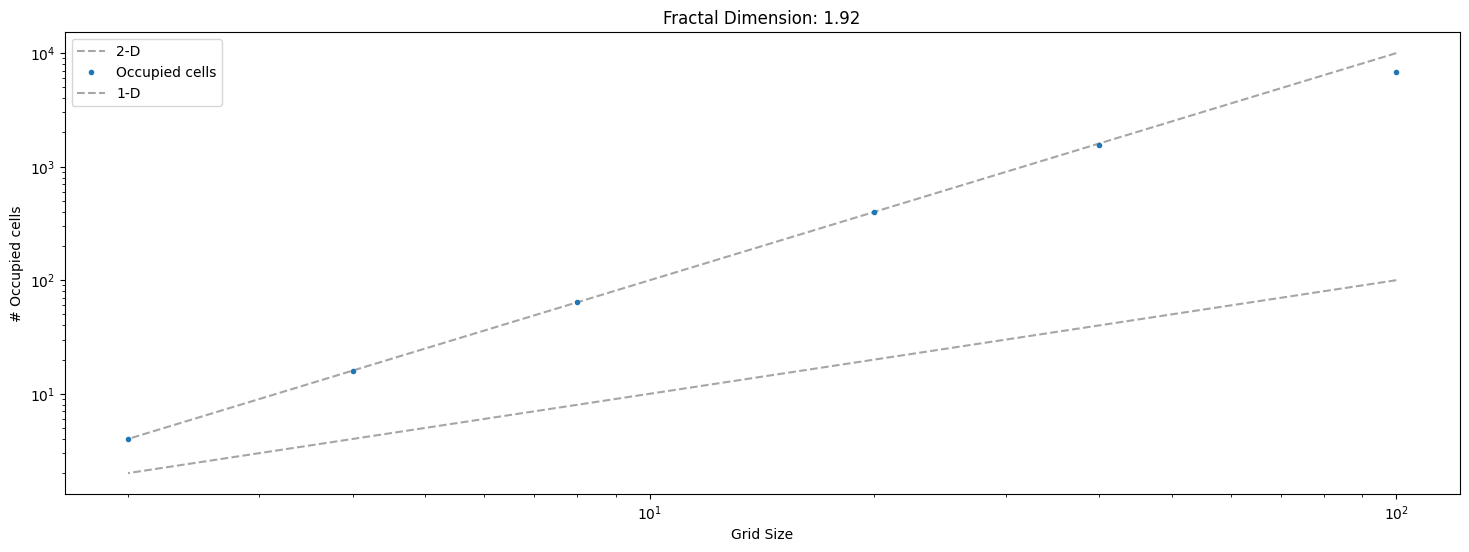

In [16]:
# Ex. 10.2 here
def log_slope(xs, ys):
    slope,*_ = linregress(np.log(xs), np.log(ys))
    return slope

def plot_scaling(fractal_test):
    xs = fractal_test.n / calibres  

    line_options = dict(linestyle='dashed', color='gray', alpha=0.7)
    plt.plot(xs, xs**2, label='2-D', **line_options)              
    plt.plot(xs, counts, '.', label=f'Occupied cells')             
    plt.plot(xs, xs, label='1-D', **line_options)                 

    title = f'Fractal Dimension: {log_slope(xs, counts):0.2f}'
    plt.gca().set(title=title, xlabel='Grid Size', ylabel='# Occupied cells', xscale='log', yscale='log')
    plt.legend()

def scaling_experiment(fractal_test):
    plt.subplots(1, figsize=(18, 6))
    plot_scaling(fractal_test)


scaling_experiment (fractal_test)



## Ex. 10.3  Scaling Experiment

In our study of Percolation patterns, we plotted the scaling factor and fractal dimension to visualize how the pattern scales compared to simple linear and square scaling.  We set up an experiment to explore how fractal dimension changed for different model paraemter values, and to idenify a critical values where [phase transitions](https://en.wikipedia.org/wiki/Phase_transition) occur.

Repeat these experiments for the `ForestFire` model.  Again, you may adapt the code developed for Percolation.

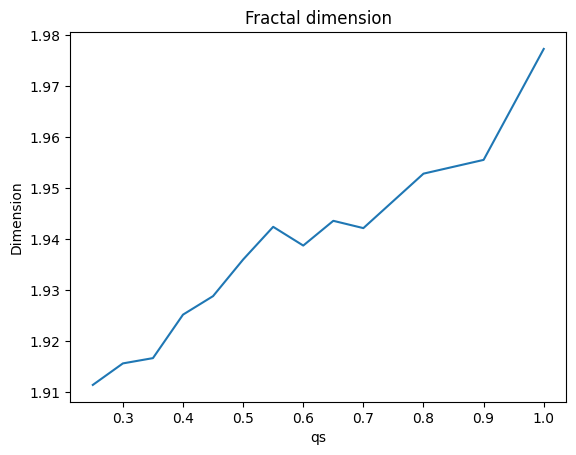

In [35]:
# Ex. 10.3 here
def fractal_dimensions_experiment(qs, n=100): #p=0.01, f=0.001 ):
    calibres = np.array([2,5,10,25,50,100])
    fractal_dimensions = []
    for q in qs:
        Frax = ForestFire(n, q) #Add p/f when looking at changes with those valeus
        for i in range (60):
          Frax.step ()
        Occu = np.array([box_count(Frax.array, i) for i in calibres])
        xs = Frax.n / calibres

        fractal_dimensions.append( log_slope(xs, Occu) )
    return fractal_dimensions


qs = [0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.80, 0.90, 1]
n = 100
#p = 0.01
#f = 0.001

x = fractal_dimensions_experiment (qs, n) #p, f)

plt.title ('Fractal dimension')
plt.xlabel ('qs')
plt.ylabel ('Dimension')
plt.plot(qs, x)
plt.show ()



### Question 10.4:
How does the fractal dimension change for different values of $p$ and $f$?
Does there appear to be a critical value where the fractal dimension goes through a phase change, like we saw for Percolation?
What conclusions might your draw about the complexity of forest edges in real forest ecosystems?  How does this compare the the man-made edges that typically result from industrial logging?

#### Answers:

When changing the value for f, the higher the probability of fire will result in more fragmented forest area, therefore relating to a more complex 'image', and having a higher fractal dimension. When changing the value for p, if p is low, there will be less trees in general, therefore creating a simpler 'image' resulting in a low fractal dimension, and when p is high, will have a more complex image, with a higher fractal dimension.

There does seem to be a criticial value change for q around 0.6, but hard to come to a conclusion that is 100% certain due to the complexity of the model, as it is a non-linear system.

A conclusion I've made is that, even though this model could be considered as quite complex, it is still no where near as complex as a real forest fire, therefore this model does give us a good idea on what to expect, but the extent of that may be limited in a sense. In a real fire, there are many other factors such as, topography, species, wind, etc

Comparing this to man-made edges, we can assume that it would be even more complex than the model shows.